# Stock Replenishment with Loaded Model

In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the saved model
MODEL_PATH = "D:\\Python\\VYPER Inventory Replenishment\\app\\stacked_model.pkl"

In [3]:
# Load the sales data
df_sales = pd.read_excel('D:\\Python\\VYPER Inventory Replenishment\\raw_data\\gopro_sales_eu.xlsx')
df_sales

,Vyper ID,Shipping Label,Date,Dispatch Date,Customer Name,Shipping Address,Currency,Amount,Delivery Amount,Discount_amount,...,Payment Status,Invoice Status,Type,Marketplace,Online Order Id,Product Brand,Product Name,SKU,QTY,Serials
0,160902,00340434654112618426,2024-12-19,2024-12-19,Oscar Opitz,"Oscar Opitz, Mühlenstr. 63, Wentorf bei Hambur...",EUR,335.29,0,0.0,...,Paid,PROCESSED,EBAY_DE,Go Pro,13-12476-90395,GoPro,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1,NaN
1,160790,00340434654112618099,2024-12-18,2024-12-19,Florian Seitz,"Florian Seitz, Grūnental 3, Detmold, DE, 32760,",EUR,335.29,0,0.0,...,Paid,PROCESSED,EBAY_DE,Go Pro,17-12470-93600,GoPro,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1,NaN
2,160700,00340434654112617832,2024-12-18,2024-12-19,Anna Vitvinova-Gerphil Denne,"Anna Vitvinova-Gerphil Denne, Rathausstraße 36...",EUR,176.46,0,0.0,...,Paid,PROCESSED,EBAY_DE,Go Pro,18-12469-40117,GoPro,GoPro HERO,CHDHF-131-EU,1,NaN
3,160622,00340434654112617511,2024-12-18,2024-12-19,Anja Seeber,"Anja Seeber, Rudolf-Breitscheid-Str. 14, Ilmen...",EUR,335.29,0,0.0,...,Paid,PROCESSED,EBAY_DE,Go Pro,13-12474-91865,GoPro,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1,NaN
4,160467,00340434654112618464,2024-12-18T15:43:46Z,2024-12-19,Tobias Wilken,"Tobias Wilken, Siemensweg 5, Schlosserei Tobia...",EUR,66.55,0,0.0,...,Paid,PROCESSED,AMAZON_DE,Amazon Berlin Silicon,302-7492807-5714725,GoPro,MAX Dual Battery Charger + Enduro Battery,ACDBD-011-EU,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,144201,00340434654112660302,2024-08-27,2024-08-28,Arturs Fadejevs,"Arturs Fadejevs, Emanuelstr 75, 47178, Duisbur...",EUR,8.39,0,0.0,...,Paid,PROCESSED,EBAY_DE,Go Pro,07-11999-02457,GoPro,Head Strap + QuickClip,ACHOM-001,1,NaN
761,144192,00340434654112660364,2024-08-27,2024-08-28,Kuluclu Yakup,"Kuluclu Yakup, Gotenstr 21, Gelsenkirchen, DE,...",EUR,336.13,0,0.0,...,Paid,PROCESSED,EBAY_DE,Go Pro,27-11978-05096,GoPro,HERO12 Black Accessory Bundle,CHDRB-121-RW,1,NaN
762,144189,00340434654112660241,2024-08-27,2024-08-28,Thorsten Jost,"Thorsten Jost, Mauggen 29b, Bockhorn, DE, 85461,",EUR,71.42,0,0.0,...,Paid,PROCESSED,EBAY_DE,Go Pro,07-11998-38078,GoPro,Media Mod (HERO9 Black),ADFMD-001,1,NaN
763,144160,00340434654112660227,2024-08-27,2024-08-27,Andreas Wittmann,"Andreas Wittmann, Schenkenstr. 11, Michelbach ...",EUR,252.09,0,0.0,...,Paid,PROCESSED,EBAY_DE,Go Pro,02-12002-38247,GoPro,GoPro HERO10 Black (Without the the Carry Case),CHDHX-102-RT,1,NaN


In [4]:
# Drop columns with all NaN values
df_sales.dropna(axis=1, how='all', inplace=True)
df_sales.head()

,Vyper ID,Shipping Label,Date,Dispatch Date,Customer Name,Shipping Address,Currency,Amount,Delivery Amount,Discount_amount,...,Full Total,Payment Status,Invoice Status,Type,Marketplace,Online Order Id,Product Brand,Product Name,SKU,QTY
0,160902,00340434654112618426,2024-12-19,2024-12-19,Oscar Opitz,"Oscar Opitz, Mühlenstr. 63, Wentorf bei Hambur...",EUR,335.29,0,0.0,...,548.90,Paid,PROCESSED,EBAY_DE,Go Pro,13-12476-90395,GoPro,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1
1,160790,00340434654112618099,2024-12-18,2024-12-19,Florian Seitz,"Florian Seitz, Grūnental 3, Detmold, DE, 32760,",EUR,335.29,0,0.0,...,548.90,Paid,PROCESSED,EBAY_DE,Go Pro,17-12470-93600,GoPro,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1
2,160700,00340434654112617832,2024-12-18,2024-12-19,Anna Vitvinova-Gerphil Denne,"Anna Vitvinova-Gerphil Denne, Rathausstraße 36...",EUR,176.46,0,0.0,...,235.63,Paid,PROCESSED,EBAY_DE,Go Pro,18-12469-40117,GoPro,GoPro HERO,CHDHF-131-EU,1
3,160622,00340434654112617511,2024-12-18,2024-12-19,Anja Seeber,"Anja Seeber, Rudolf-Breitscheid-Str. 14, Ilmen...",EUR,335.29,0,0.0,...,548.90,Paid,PROCESSED,EBAY_DE,Go Pro,13-12474-91865,GoPro,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1
4,160467,00340434654112618464,2024-12-18T15:43:46Z,2024-12-19,Tobias Wilken,"Tobias Wilken, Siemensweg 5, Schlosserei Tobia...",EUR,66.55,0,0.0,...,74.96,Paid,PROCESSED,AMAZON_DE,Amazon Berlin Silicon,302-7492807-5714725,GoPro,MAX Dual Battery Charger + Enduro Battery,ACDBD-011-EU,1


In [5]:
# Remove '12:35:57+00:00' from 'Date' column
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%Y-%m-%d %H:%M:%S')
df_sales['Date'] = df_sales['Date'].astype(str)
df_sales['Date'] = df_sales['Date'].str.split(' ').str[0]
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
df_sales.head()

,Vyper ID,Shipping Label,Date,Dispatch Date,Customer Name,Shipping Address,Currency,Amount,Delivery Amount,Discount_amount,...,Full Total,Payment Status,Invoice Status,Type,Marketplace,Online Order Id,Product Brand,Product Name,SKU,QTY
0,160902,00340434654112618426,2024-12-19,2024-12-19,Oscar Opitz,"Oscar Opitz, Mühlenstr. 63, Wentorf bei Hambur...",EUR,335.29,0,0.0,...,548.90,Paid,PROCESSED,EBAY_DE,Go Pro,13-12476-90395,GoPro,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1
1,160790,00340434654112618099,2024-12-18,2024-12-19,Florian Seitz,"Florian Seitz, Grūnental 3, Detmold, DE, 32760,",EUR,335.29,0,0.0,...,548.90,Paid,PROCESSED,EBAY_DE,Go Pro,17-12470-93600,GoPro,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1
2,160700,00340434654112617832,2024-12-18,2024-12-19,Anna Vitvinova-Gerphil Denne,"Anna Vitvinova-Gerphil Denne, Rathausstraße 36...",EUR,176.46,0,0.0,...,235.63,Paid,PROCESSED,EBAY_DE,Go Pro,18-12469-40117,GoPro,GoPro HERO,CHDHF-131-EU,1
3,160622,00340434654112617511,2024-12-18,2024-12-19,Anja Seeber,"Anja Seeber, Rudolf-Breitscheid-Str. 14, Ilmen...",EUR,335.29,0,0.0,...,548.90,Paid,PROCESSED,EBAY_DE,Go Pro,13-12474-91865,GoPro,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1
4,160467,00340434654112618464,2024-12-18,2024-12-19,Tobias Wilken,"Tobias Wilken, Siemensweg 5, Schlosserei Tobia...",EUR,66.55,0,0.0,...,74.96,Paid,PROCESSED,AMAZON_DE,Amazon Berlin Silicon,302-7492807-5714725,GoPro,MAX Dual Battery Charger + Enduro Battery,ACDBD-011-EU,1


In [6]:
# Drop unnecessary columns
df_sales.drop(columns=['Vyper ID', 'Shipping Label', 'Dispatch Date', 'Currency', 'Delivery Amount', 
                       'Discount_amount','Payment Status', 'Invoice Status', 'Marketplace', 'Online Order Id','Product Brand'], inplace=True)
df_sales.head()

,Date,Customer Name,Shipping Address,Amount,Tax amount,Full Total,Type,Product Name,SKU,QTY
0,2024-12-19,Oscar Opitz,"Oscar Opitz, Mühlenstr. 63, Wentorf bei Hambur...",335.29,213.61,548.90,EBAY_DE,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1
1,2024-12-18,Florian Seitz,"Florian Seitz, Grūnental 3, Detmold, DE, 32760,",335.29,213.61,548.90,EBAY_DE,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1
2,2024-12-18,Anna Vitvinova-Gerphil Denne,"Anna Vitvinova-Gerphil Denne, Rathausstraße 36...",176.46,59.17,235.63,EBAY_DE,GoPro HERO,CHDHF-131-EU,1
3,2024-12-18,Anja Seeber,"Anja Seeber, Rudolf-Breitscheid-Str. 14, Ilmen...",335.29,213.61,548.90,EBAY_DE,GoPro HERO13 Black Accessory Bundle,CHDRB-131-RW,1
4,2024-12-18,Tobias Wilken,"Tobias Wilken, Siemensweg 5, Schlosserei Tobia...",66.55,8.41,74.96,AMAZON_DE,MAX Dual Battery Charger + Enduro Battery,ACDBD-011-EU,1


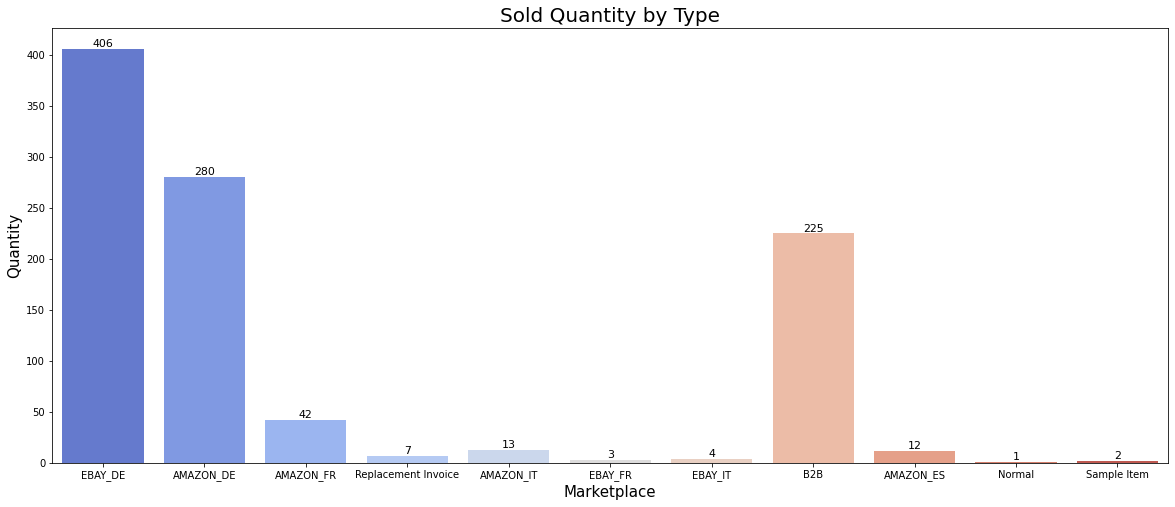

In [7]:
plt.figure(figsize=(20, 8))
sns.barplot(x='Type', y='QTY', data=df_sales, ci=None, estimator=sum, palette='coolwarm')
# Display value on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f"{int(p.get_height()):,}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                       textcoords='offset points')
plt.title('Sold Quantity by Type', fontsize=20)
plt.xlabel('Marketplace', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.show()

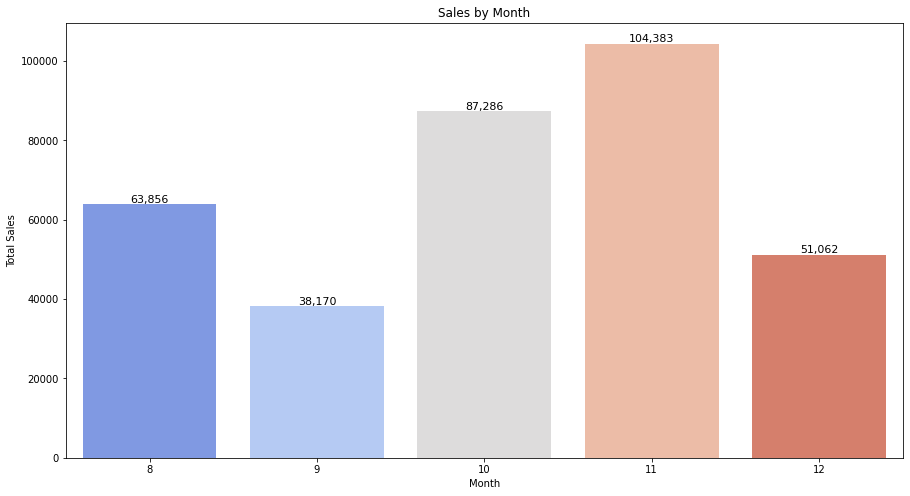

In [8]:
plt.figure(figsize=(15, 8))
sns.barplot(x=df_sales['Date'].dt.month, y='Full Total', data=df_sales, ci=None, estimator=sum, palette='coolwarm')
# Display value on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f"{int(p.get_height()):,}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                       textcoords='offset points')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

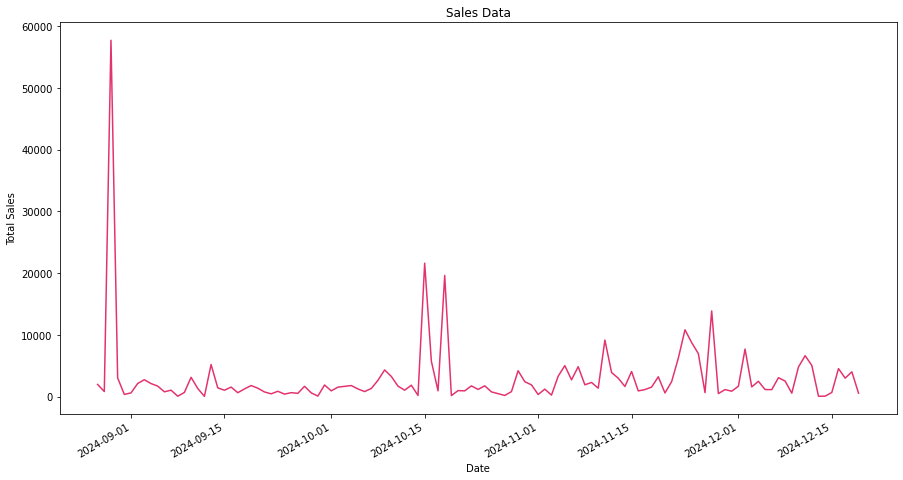

In [9]:
df_sales.groupby('Date')['Full Total'].sum().plot(kind='line', subplots=True, figsize=(15, 8), color='#e33270')
plt.title('Sales Data')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

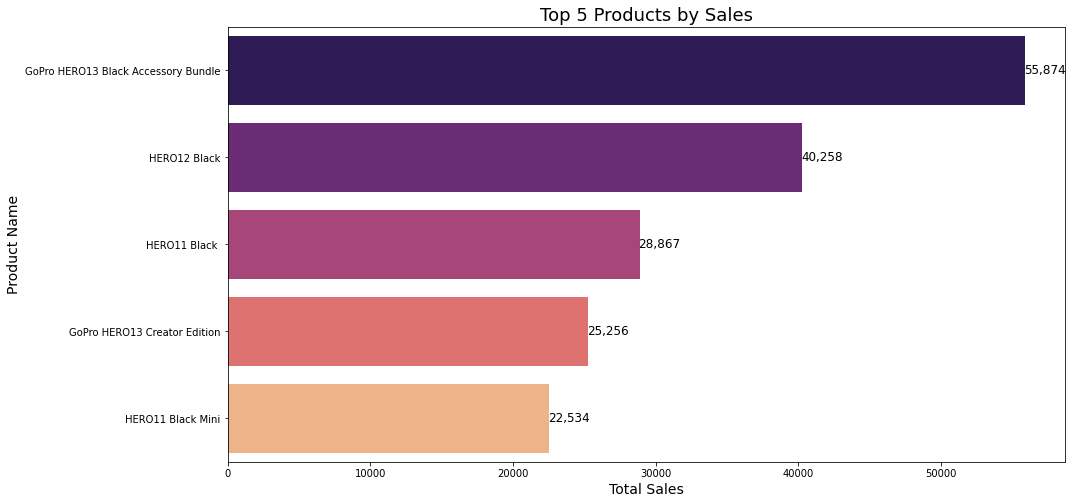

In [10]:
# Top 5 products by sales
fig, ax = plt.subplots(figsize=(15, 8))
top_5_sales = sns.barplot(data=df_sales.groupby('Product Name')['Full Total'].sum().sort_values(ascending=False).head(5).reset_index(), y='Product Name', x='Full Total', palette='magma')
for p in ax.patches:
    ax.annotate(f"{int(p.get_width()):,}", (p.get_width(), p.get_y() + p.get_height() / 2.), ha='center', va='center', fontsize=12, color='black', xytext=(20, 0), textcoords='offset points')
    
plt.title('Top 5 Products by Sales', fontsize=18)
plt.xlabel('Total Sales', fontsize=14)
plt.ylabel('Product Name', fontsize=14)
plt.show()

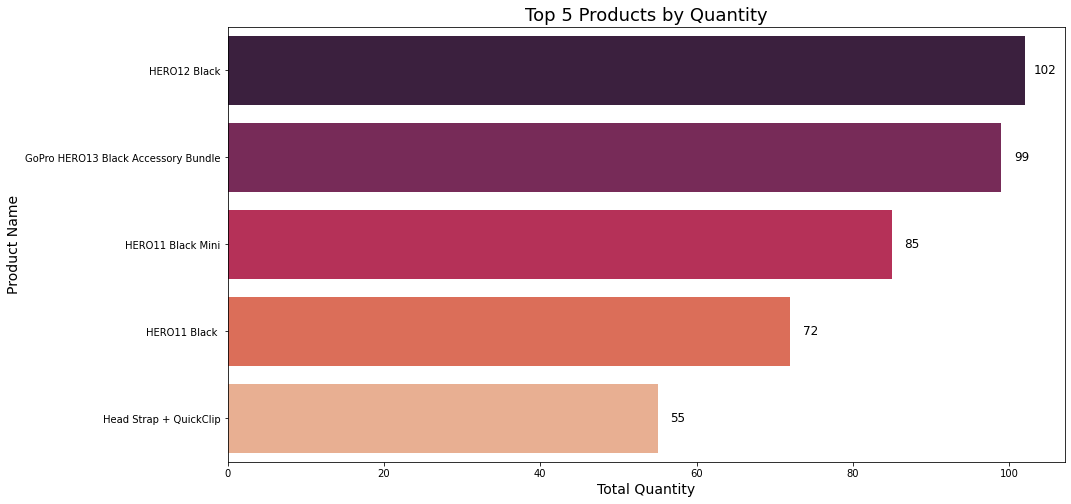

In [11]:
# Top 5 products by quantity
fig, ax = plt.subplots(figsize=(15, 8))
top_5_qty = sns.barplot(data=df_sales.groupby('Product Name')['QTY'].sum().sort_values(ascending=False).head(5).reset_index(), y='Product Name', x='QTY', palette='rocket')
for p in ax.patches:
    ax.annotate(f"{int(p.get_width()):,}", (p.get_width(), p.get_y() + p.get_height() / 2.), ha='center', va='center', fontsize=12, color='black', xytext=(20, 0), textcoords='offset points')
plt.title('Top 5 Products by Quantity', fontsize=18)
plt.xlabel('Total Quantity', fontsize=14)
plt.ylabel('Product Name', fontsize=14)
plt.show()

In [12]:
# Load Stock Data
df_stock = pd.read_excel('D:\\Python\\VYPER Inventory Replenishment\\raw_data\\gopro_stock_eu.xlsx', skiprows=3)
df_stock.reset_index(drop=True, inplace=True)
df_stock.head()

,Stock Item,Brand Name,SKU,Initial Stock,Stock In,Stock Out,Stock On Hand,Manual Count,Variance,Cost,Total
0,GoPro HERO Session,GoPro,CHDNH-B13,0.0,0.0,0.0,0.0,NaN,NaN,44.62,0.0
1,GoPro HERO6 Black Refurb,GoPro,CHDNH-B17,0.0,0.0,0.0,0.0,NaN,NaN,114.74,0.0
2,GoPro HERO5 Session Refurb,GoPro,CHDNH-B16,0.0,0.0,0.0,0.0,NaN,NaN,81.11,0.0
3,GoPro HERO5 Black Refurb,GoPro,CHDNH-B15,0.0,0.0,0.0,0.0,NaN,NaN,89.24,0.0
4,GoPro HERO4 Black Refurb,GoPro,CHDNH-B11,0.0,0.0,0.0,0.0,NaN,NaN,70.12,0.0


In [13]:
# Delete last row
df_stock.drop(df_stock.tail(1).index, inplace=True)
df_stock.tail()

,Stock Item,Brand Name,SKU,Initial Stock,Stock In,Stock Out,Stock On Hand,Manual Count,Variance,Cost,Total
311,HERO 8 Black - Non Packaged,GoPro,CHDHX-801-RW-NP,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0
312,Flexible Grip Mount (Featuring Gear Ties),GoPro,AGRTM-002,12.0,0.0,0.0,12.0,NaN,NaN,20.25,243.0
313,GoPro SWAG - Frisbee/Towel/Box,GoPro,GP-SWAG-BDL-001,138.0,0.0,0.0,138.0,NaN,NaN,0.00,0.0
314,GoPro HERO13 Black SWAG Bundle,GoPro,CHDHX-131-RW-SWAG,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0
315,HERO12 Black - Non Packaged,GoPro,CHDHX-121-RW-NP,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0


In [14]:
# Drop columns with all NaN values
df_stock.dropna(axis=1, how='all', inplace=True)
df_stock.head()

,Stock Item,Brand Name,SKU,Initial Stock,Stock In,Stock Out,Stock On Hand,Cost,Total
0,GoPro HERO Session,GoPro,CHDNH-B13,0.0,0.0,0.0,0.0,44.62,0.0
1,GoPro HERO6 Black Refurb,GoPro,CHDNH-B17,0.0,0.0,0.0,0.0,114.74,0.0
2,GoPro HERO5 Session Refurb,GoPro,CHDNH-B16,0.0,0.0,0.0,0.0,81.11,0.0
3,GoPro HERO5 Black Refurb,GoPro,CHDNH-B15,0.0,0.0,0.0,0.0,89.24,0.0
4,GoPro HERO4 Black Refurb,GoPro,CHDNH-B11,0.0,0.0,0.0,0.0,70.12,0.0


In [15]:
# Convert float64 columns to int64
df_stock = df_stock.astype({'Initial Stock': 'int64','Stock In': 'int64', 'Stock Out': 'int64', 'Stock On Hand': 'int64'})
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Stock Item     316 non-null    object 
 1   Brand Name     316 non-null    object 
 2   SKU            316 non-null    object 
 3   Initial Stock  316 non-null    int64  
 4   Stock In       316 non-null    int64  
 5   Stock Out      316 non-null    int64  
 6   Stock On Hand  316 non-null    int64  
 7   Cost           316 non-null    float64
 8   Total          316 non-null    float64
dtypes: float64(2), int64(4), object(3)
memory usage: 22.3+ KB


In [16]:
# Drop unnecessary columns
df_stock.drop(columns=['Brand Name', 'Initial Stock', 'Stock In', 'Stock Out'], inplace=True)
df_stock.head()

,Stock Item,SKU,Stock On Hand,Cost,Total
0,GoPro HERO Session,CHDNH-B13,0,44.62,0.0
1,GoPro HERO6 Black Refurb,CHDNH-B17,0,114.74,0.0
2,GoPro HERO5 Session Refurb,CHDNH-B16,0,81.11,0.0
3,GoPro HERO5 Black Refurb,CHDNH-B15,0,89.24,0.0
4,GoPro HERO4 Black Refurb,CHDNH-B11,0,70.12,0.0


In [17]:
# Aggregate sales data to daily level
daily_sales = df_sales.groupby('Date')['QTY'].sum().reset_index()

In [18]:
# Calculate the rolling statistics
daily_sales['Rolling_Mean_7'] = daily_sales['QTY'].rolling(window=7).mean()
daily_sales['Rolling_Std_7'] = daily_sales['QTY'].rolling(window=7).std()

# Add lag features
daily_sales['Lag_1'] = daily_sales['QTY'].shift(1)
daily_sales['Lag_7'] = daily_sales['QTY'].shift(7)

daily_sales.fillna(0, inplace=True)

# Create additional time-based features
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.dayofweek
daily_sales['Month'] = daily_sales['Date'].dt.month

daily_sales

,Date,QTY,Rolling_Mean_7,Rolling_Std_7,Lag_1,Lag_7,DayOfWeek,Month
0,2024-08-27,6,0.000000,0.000000,0.0,0.0,1,8
1,2024-08-28,4,0.000000,0.000000,6.0,0.0,2,8
2,2024-08-29,57,0.000000,0.000000,4.0,0.0,3,8
3,2024-08-30,4,0.000000,0.000000,57.0,0.0,4,8
4,2024-08-31,1,0.000000,0.000000,4.0,0.0,5,8
...,...,...,...,...,...,...,...,...
108,2024-12-15,3,6.571429,6.133437,2.0,7.0,6,12
109,2024-12-16,13,8.285714,5.992058,3.0,1.0,0,12
110,2024-12-17,7,7.714286,5.879747,13.0,11.0,1,12
111,2024-12-18,10,6.714286,4.461475,7.0,17.0,2,12


In [19]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(daily_sales[['QTY', 'Rolling_Mean_7', 'Rolling_Std_7', 'Lag_1', 'Lag_7', 'DayOfWeek', 'Month']])

In [20]:
# Load the saved stacked model
if os.path.exists(MODEL_PATH):
    stacked_model = joblib.load(MODEL_PATH)
    print('Stacked Model loaded successfully!')
else:
    print('Model not found!')

Stacked Model loaded successfully!


In [21]:
# Prepare input for prediction
sequence_length = 14
num_features = scaled_data.shape[1]
X_input = []
for i in range(len(scaled_data) - sequence_length):
    X_input.append(scaled_data[i:i+sequence_length])
X_input = np.array(X_input)

In [22]:
# Load trained models
lstm_model = load_model('D:\\Python\\VYPER Inventory Replenishment\\app\\best_lstm_model.h5')
cnn_model = load_model('D:\\Python\\VYPER Inventory Replenishment\\app\\best_cnn_model.h5')

# Reshape input from (samples, sequence_length, features) to (samples, features)
X_input_lstm_cnn = X_input[-30:]

# Get Predictions
lstm_predictions = lstm_model.predict(X_input_lstm_cnn)
cnn_predictions = cnn_model.predict(X_input_lstm_cnn)

# Stack predictions for RandomForest Regressor
stacked_features = np.column_stack((lstm_predictions.flatten(), cnn_predictions.flatten()))

# Make predictions
future_predictions = stacked_model.predict(stacked_features)

# Rescale the predictions back to the original scale
future_predictions_rescaled = scaler.inverse_transform(
    np.column_stack([future_predictions.reshape(-1, 1), 
                     np.zeros((future_predictions.shape[0], num_features - 1))])
)[:, 0]


1/1 [==============================] - 0s 107ms/step


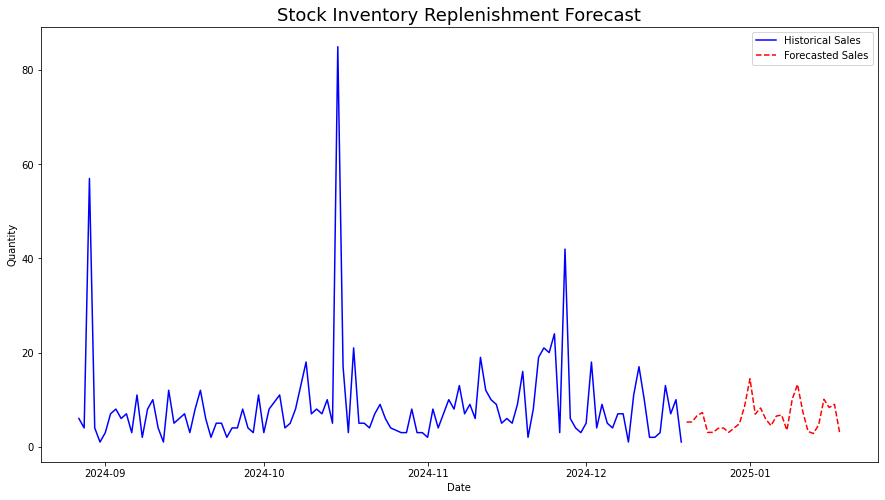

In [24]:
# Visualize the predictions
plt.figure(figsize=(15, 8))
plt.plot(daily_sales['Date'], daily_sales['QTY'], label='Historical Sales', color='blue')
future_dates = pd.date_range(start=daily_sales['Date'].max() + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates, future_predictions_rescaled, label='Forecasted Sales', color='red', linestyle='--')
plt.legend()
plt.title('Stock Inventory Replenishment Forecast', fontsize=18)
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

In [27]:
# Restock Calculations
last_30_days_sales = df_sales[df_sales['Date'] > df_sales['Date'].max() - pd.Timedelta(days=30)]
last_30_days_sales = last_30_days_sales.groupby(['SKU', 'Product Name'])['QTY'].sum().reset_index()
last_30_days_sales.columns = ['SKU', 'Product Name','Last_30_Days_Sales']

current_stock_levels = df_stock.groupby('SKU')['Stock On Hand'].sum().reset_index()
current_stock_levels.columns = ['SKU', 'Current_Stock']

restock_skus = pd.merge(last_30_days_sales, current_stock_levels, on='SKU')
average_daily_forecast = future_predictions_rescaled.mean()

# Calculate restock quantity considering forecasted demand and current stock
restock_skus['Restock_Quantity'] = restock_skus.apply(
    lambda x: max(0, x['Last_30_Days_Sales'] - x['Current_Stock'] + average_daily_forecast), axis=1
)

# Set Restock Quantity to whole integer values (rounded up)
restock_skus['Restock_Quantity'] = restock_skus['Restock_Quantity'].apply(np.ceil).astype(int)

# Adjust Restock Quantity to be in multiples of 6
restock_skus['Restock_Quantity'] = restock_skus['Restock_Quantity'].apply(lambda x: x + (6 - x % 6) if x % 6 != 0 else x)

# Ensure Restock Quantity is zero if Current Stock is greater than or equal to Forecasted Demand
restock_skus['Restock_Quantity'] = restock_skus.apply(
    lambda x: 0 if x['Current_Stock'] >= x['Last_30_Days_Sales'] else x['Restock_Quantity'], axis=1
)

# Restock quantity not required for SKUs start with 'UKRFB
restock_skus = restock_skus[~restock_skus['SKU'].str.startswith('UKRFB')]

# Restock quantity not required for SKUs start with 'DERFB'
restock_skus = restock_skus[~restock_skus['SKU'].str.startswith('DERFB')]

# Restock quantity not required for SKUs ends with '- R'
restock_skus = restock_skus[~restock_skus['SKU'].str.endswith('- R')].reset_index(drop=True)

In [29]:
# Display the SKUs that need restocking with the calculated restock quantities
print("SKUs that need restocking with required quantities:")
display(restock_skus[['SKU', 'Product Name', 'Last_30_Days_Sales', 'Current_Stock', 'Restock_Quantity']])

SKUs that need restocking with required quantities:


,SKU,Product Name,Last_30_Days_Sales,Current_Stock,Restock_Quantity
0,ABSSC-002,GoPro Casey,39,10,36
1,ACBAT-011,MAX Enduro Battery,3,8,0
2,ACDBD-011-EU,MAX Dual Battery Charger + Enduro Battery,1,11,0
3,ADBAT-011,GoPro Enduro Rechargeable Li-Ion Battery for H...,4,13,0
4,ADCOD-001,USB Pass-Through Door (HERO9 Black),9,2,18
5,ADDBD-211-EU,Dual Battery Charger + Enduro,6,2,12
6,ADFMD-001,Media Mod (HERO9 Black),4,3,12
7,ADSST-001,Sleeve + Lanyard (HERO9 Black) Black,3,15,0
8,ADWAL-001,HERO9 BLACK Max Lens Mod,3,9,0
9,AEBAT-001,Enduro for HERO13 Black,2,148,0


In [30]:
# Highlight the SKUs that need restocking above a certain threshold with a color
def highlight_restock(x):
    color = 'background-color: #6dc009' if x['Restock_Quantity'] > 0 else ''
    return [color for _ in x]

restock_skus.style.apply(highlight_restock, axis=1)

,SKU,Product Name,Last_30_Days_Sales,Current_Stock,Restock_Quantity
0,ABSSC-002,GoPro Casey,39,10,36
1,ACBAT-011,MAX Enduro Battery,3,8,0
2,ACDBD-011-EU,MAX Dual Battery Charger + Enduro Battery,1,11,0
3,ADBAT-011,GoPro Enduro Rechargeable Li-Ion Battery for HERO9/10 Black,4,13,0
4,ADCOD-001,USB Pass-Through Door (HERO9 Black),9,2,18
5,ADDBD-211-EU,Dual Battery Charger + Enduro,6,2,12
6,ADFMD-001,Media Mod (HERO9 Black),4,3,12
7,ADSST-001,Sleeve + Lanyard (HERO9 Black) Black,3,15,0
8,ADWAL-001,HERO9 BLACK Max Lens Mod,3,9,0
9,AEBAT-001,Enduro for HERO13 Black,2,148,0
